# Distinguishing Particles in Brightfield Microscopy

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS141_distinguishing_particles_in_brightfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# !pip install deeplay deeptrack  # Uncomment if running on Colab/Kaggle.

This tutorial demonstrates how to use a U-net to track and distinguish particles of different sizes in brightfield microscopy.

In [1]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

## 1. Defining the Particles

Consider spherical particles of two different sizes. The particles are instances of the `Sphere` class, which takes the following inputs:

- `position`: The lateral position of the particle.

- `z` (optional): The axial distance of the particle perpendicualr to the focal plane.

- `position_unit`: "pixel" or "meter", defines the scale factor of the particle position.

- `radius`: The radius of the particle in meters.

- `refractive_index`: The refractive index of the particle.

In this example, the positions of the particles are randomly sampled with a lateral position between 0 and 256 pixels in the focal plane, and an axial position between -10 to 10 pixels from the focal plane. The smaller particle has a radius between 200 and 250 nm, while the larger has a radius between 400 and 500 nm. The real part of their refractive index is 1.45, while the imaginary part is between 0.02 and 0.03 (corresponding to the absorption coefficient). Finally, you define a dummy-property, `particle_type`, to distinguish between the particles.

In [2]:
small_particle = dt.Sphere(
    position=lambda: np.random.rand(2) * 128,
    z=lambda: - 10 + np.random.rand() * 20,
    position_unit="pixel",
    radius=lambda: 200e-9 + np.random.rand() * 50e-9,
    refractive_index=lambda: 1.45 + (0.02j + np.random.rand() * 0.01j),
    particle_type = 0,
)

large_particle = dt.Sphere(
    position=lambda: np.random.rand(2) * 128,
    z=lambda: -10 + np.random.rand() * 20,
    position_unit="pixel",
    radius=lambda: 400e-9 + np.random.rand() * 100e-9,
    refractive_index=lambda: 1.45 + (0.02j + np.random.rand() * 0.01j),
    particle_type = 1,
)

## 2. Defining the Optics 

Next, you need to define the properties of the optical system. Here, you use the `Brightfield` class, which uses particles with a defined refractive index and illuminates them coherently (see also [optics_example](../3-advanced-topics/DTAT323_optics.ipynb)). It takes the following inputs:

- `wavelength`: The wavelength of the illuminting light (m).

- `NA`: The numerical aperature.

- `resolution`: The effective camera pixel size (m).

- `magnification`: The magnification of the optical device.

- `output_region`: The position and size of the camera sensor in pixels `(x, y, width_x, width_y)`.

- `refractive_index_medium`: The refractive index of the medium where the scatterers are immersed.

- `illumination`: The light illuminating to the sample (if undefined, the sample is illuminated homogenously with intensity 1).

To simulate incoherent white light, you define multiple independent optical devices in a range of wavelengths from 400 to 700 nm. The number of optical devices is a trade-off between accuracy and speed: in most cases a few (~3) wavelengths will be enough. Moreover, you create an instance of the `IlluminationGradient`  class, which adds an intensity gradient to the illuminating light.

In [3]:
spectrum = np.linspace(400e-9, 700e-9, 3)

illumination_gradient = \
    dt.IlluminationGradient(gradient=lambda: np.random.randn(2) * 0.0002)

brightfield_microscope = [
    dt.Brightfield(
        wavelength=wavelength,
        NA=1,
        resolution=1e-6,
        magnification=10,
        refractive_index_medium=1.33,
        illumination=illumination_gradient,
        upsample=2,
        output_region=(0, 0, 128, 128),
    )
    for wavelength in spectrum
]

## 3. Defining the Noise

The noise in the system is Gaussian with a standard deviation of 0.01.

In [4]:
noise = dt.Gaussian(sigma=0.1)

## 4. Combining the Features 

The sample contains 5 to 24 small particles, and 5 to 24 large particles. It is illuminated with the brightfield optics defined above. You use the Python function `sum()` to add the optical devices together. This is equivalent to the more verbose statement `optics[0](sample) + optics[1](sample) + ...`

In [5]:
number_of_small_particles = lambda: np.random.randint(5, 15)
number_of_large_particles = lambda: np.random.randint(5, 15)

sample = (
    (small_particle ^ number_of_small_particles)
    &
    (large_particle ^ number_of_large_particles)
)

incoherently_illuminated_sample = sum([
    brightfield_microscope_one_wavelegth(sample) 
    for brightfield_microscope_one_wavelegth in brightfield_microscope
])

## 5. Augmenting the Images

Simulating many images is slow. Thus, to speed up the training, you can use augmentations. These are special features to resolve more images before resolving the base feature (`brightfield_microscope_one_wavelegth`). You will use three augmentations: `FlipLR`, which mirrors the image left to right; `FlipUD`, which mirrors the image up to down; and `FlipDiagonal`, which mirrors the image along the main diagonal. This results in an 8-fold increase in the numebr of images, and thus in the speed of the code (roughly).

Therefore, you add the noise after the augmentation as a cheap way to make the images even more diverse.

Finally, you normalize the images using `NormalizeMinMax`, which transforms the images to values between 0 and 1.

In [6]:
image_of_particles = (
    incoherently_illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
)

## 5. Plotting Some Example Images

Now, visualize some example images. At each iteration, call the method `.update()` to refresh the random features in the image (particle number, particle position, Poisson noise, etc.). Afterwards, call the method `.plot()` to generate and display the image.

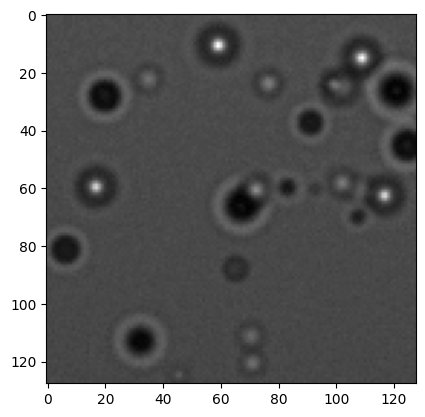

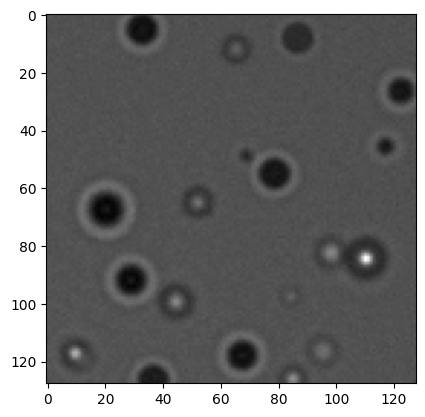

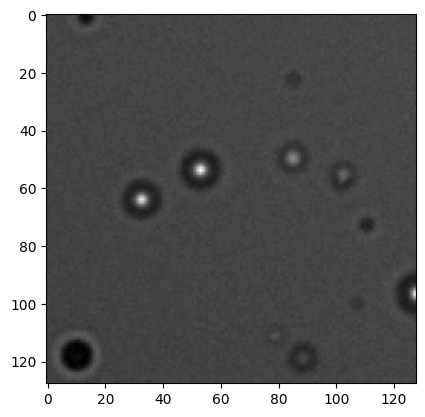

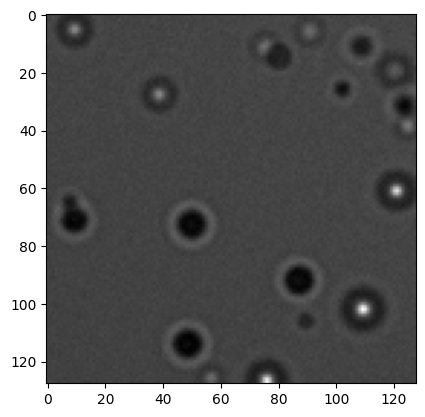

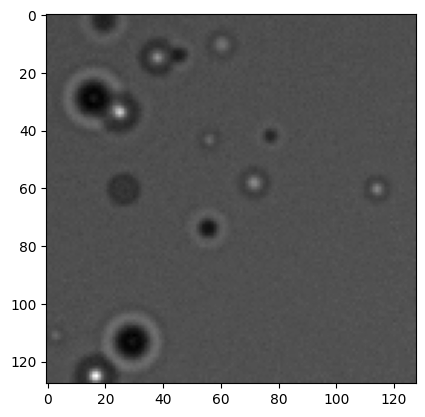

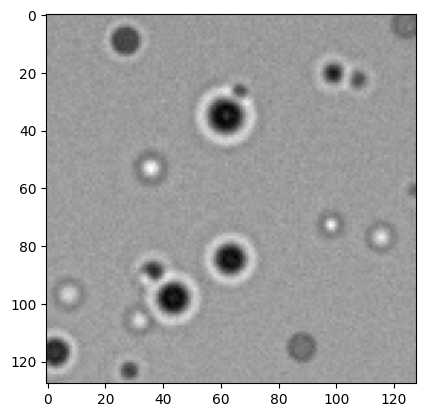

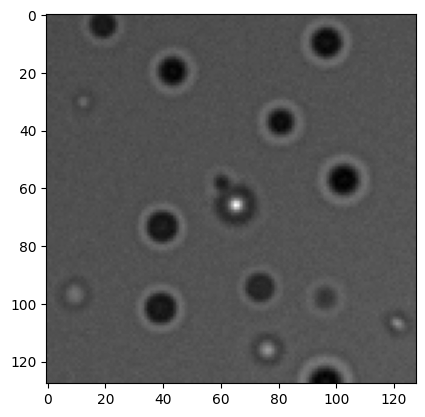

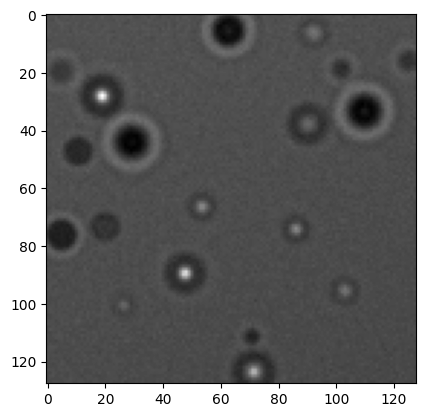

In [7]:
for _ in range(8):
   image_of_particles.update()
   image_of_particles.plot(cmap="gray")
   plt.show()

## 6. Creating the Target Images

You can now define a function that uses the generated images to create the target images to be used in the training. The target is an image of shape `(256, 256, 3)`, where the last dimension represents three classes. In other words, each pixel in the input image is classified into one of three classes:

1. The first class is the null-class, representing the background. A pixel belongs to the null class if it does not belong to any other class. 

2. The second class is 1 if the pixel is within 3 pixels of a small particle.

3. The third class is 1 if the pixel is within 3 pixels of a large particle.

In [10]:
image_of_particles.store_properties()  # Store the properties of the particles.

def get_target_image(image_of_particles):
    """Get the target image from the image of particles."""
    
    label = np.zeros(image_of_particles.shape[:2]).astype(int)
    
    x, y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]), 
        np.arange(0, image_of_particles.shape[1]),
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]
            distance_map = (x - position[1]) ** 2 + (y - position[0]) ** 2
            label[distance_map < 9] = (property["particle_type"] + 1)
            
    return label

You will also show images and targets side by side to verify that the targets are generated correctly.

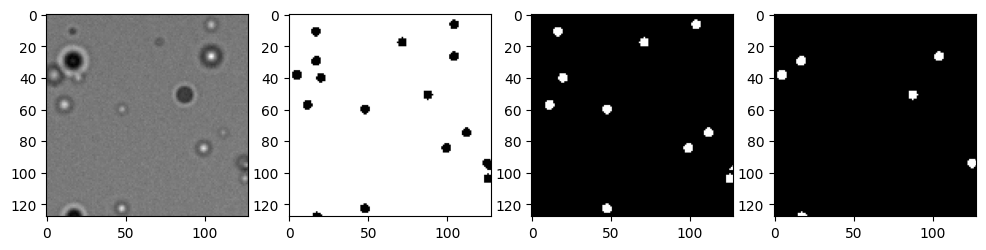

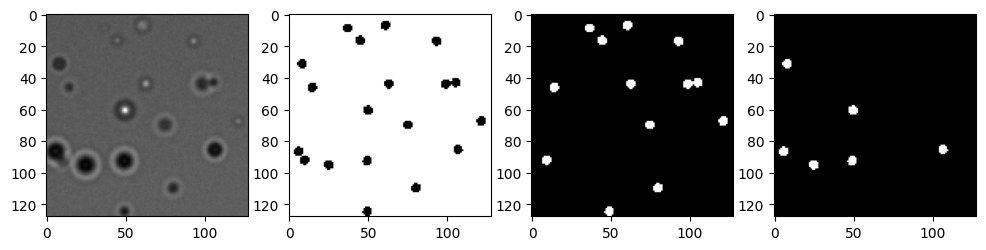

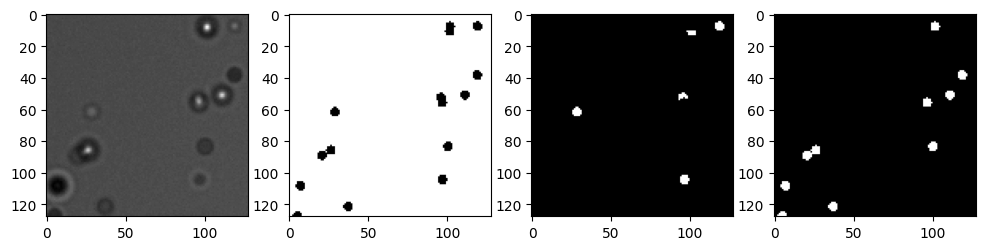

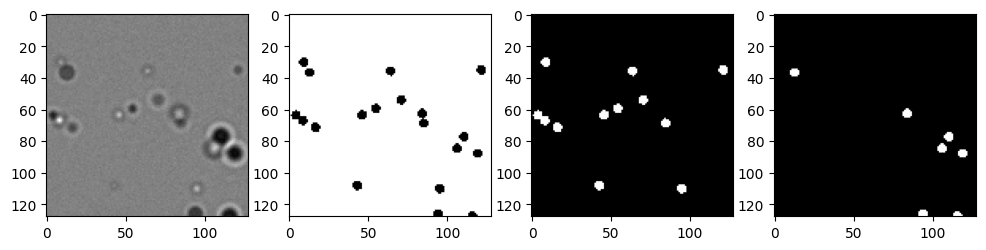

In [11]:
for i in range(4):
    image = image_of_particles.update().resolve()
    
    label_of_particles = get_target_image(image)
    
    plt.figure(figsize=(12, 9))
    
    plt.subplot(1, 4,1)
    plt.imshow(image[..., 0], cmap="gray")
    
    plt.subplot(1,4,2)
    plt.imshow(label_of_particles == 0, cmap="gray")
    
    plt.subplot(1,4,3)
    plt.imshow(label_of_particles == 1, cmap="gray")
    
    plt.subplot(1,4,4)
    plt.imshow(label_of_particles == 2, cmap="gray")

    plt.show()

## 7. Defining the Neural Network Model

The neural network architecture used is a U-net, which is a fully convoltional model used for image to image transformations. You will add a softmax activation to the final layer.

In [13]:
import deeptrack.deeplay as dl
import torchmetrics as tm
import torch

net = dl.UNet2d(
    in_channels=1,
    channels=[32, 64, 128],
    out_channels=3,
)

unet_reg = dl.Regressor(
    model=net,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=dl.Adam(lr=1e-3),
    metrics=[tm.F1Score(task="multiclass", num_classes=3)],
).create()

print(unet_reg)

Regressor(
  (loss): CrossEntropyLoss()
  (optimizer): Adam[Adam](lr=0.001)
  (train_metrics): MetricCollection(
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=test
  )
  (model): UNet2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Conv2dBlock(
          (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): R

## 8. Training the Model

The model is trained by calling `.fit()`. This will take several few minutes on GPU.

In [14]:
# Prepare data generation pipeline for training.
data_pipeline = (
    (
        image_of_particles 
        >> dt.MoveAxis(-1, 0) 
        >> dt.pytorch.ToTensor(dtype=torch.float)
    ) 
    & 
    (
        image_of_particles 
        >> get_target_image 
        >> dt.pytorch.ToTensor(dtype=torch.long)
    )
)

dataset = dt.pytorch.Dataset(
    data_pipeline,
    length=640,
    replace=0.1,
)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
)

unet_trainer = dl.Trainer(
    max_epochs=200,
    accelerator="auto",
)

unet_trainer.fit(unet_reg, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ UNet2d           │  512 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 512 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 512 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


You can now plot the training history.

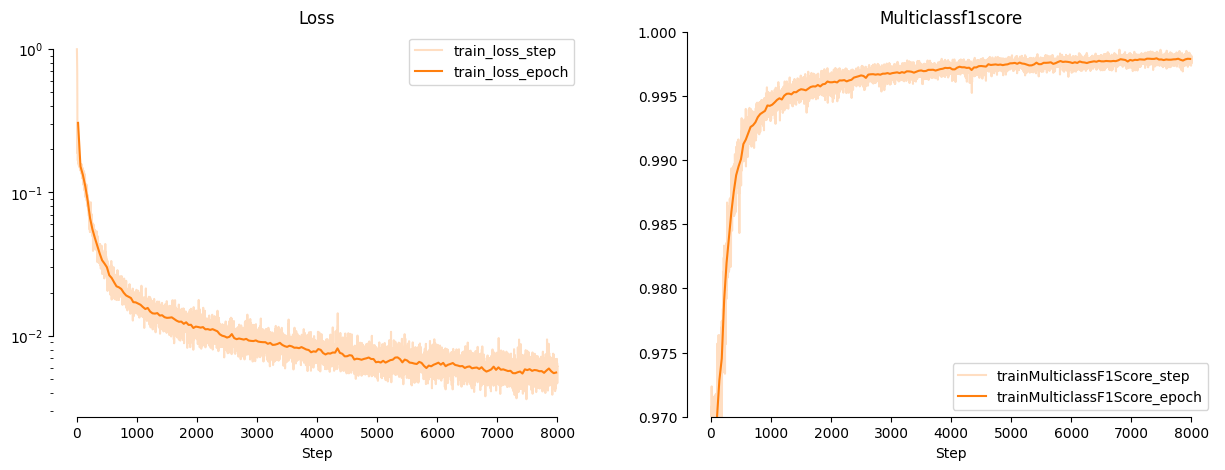

In [15]:
import seaborn as sns

fig, ax = unet_trainer.history.plot()
ax[1].set_ylim(0.97, 1)
ax[1].set_yscale("linear")
sns.despine(fig, trim=True)

## 9. Visualizing the Model Performance

Finally, evaluate the model performance by showing the model output beside the input image and the ground truth. 

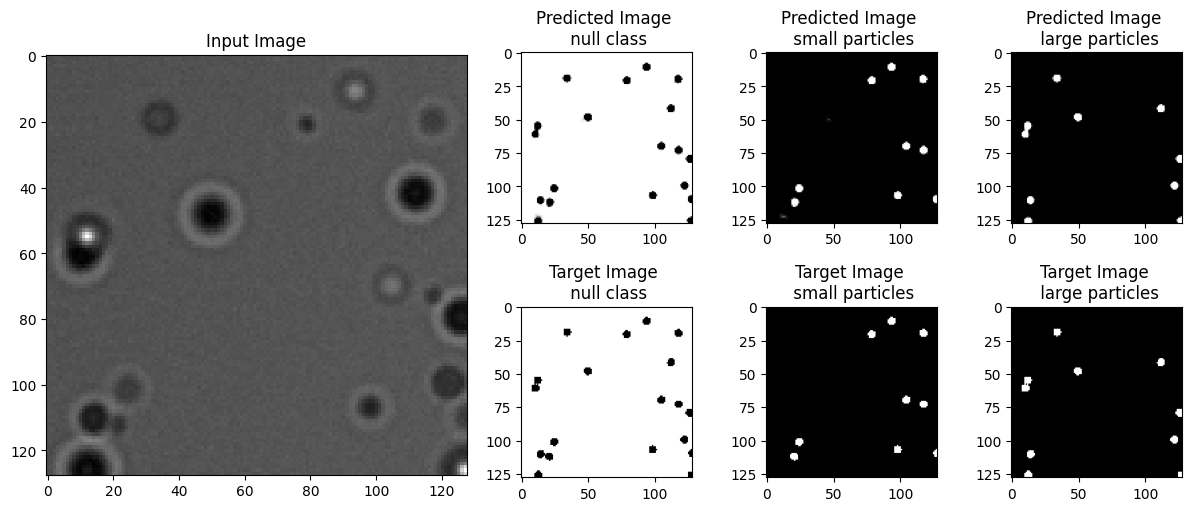

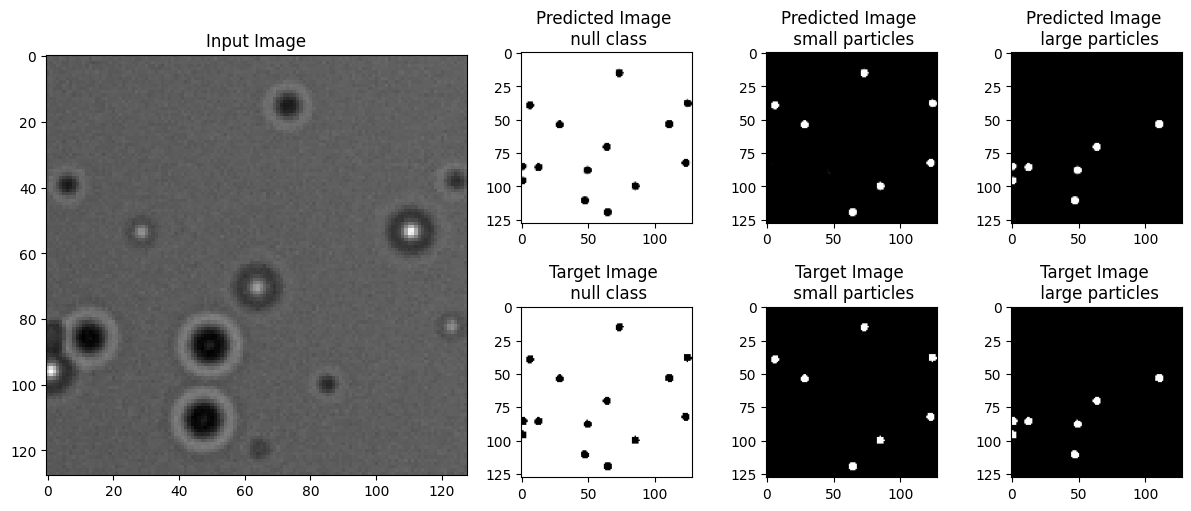

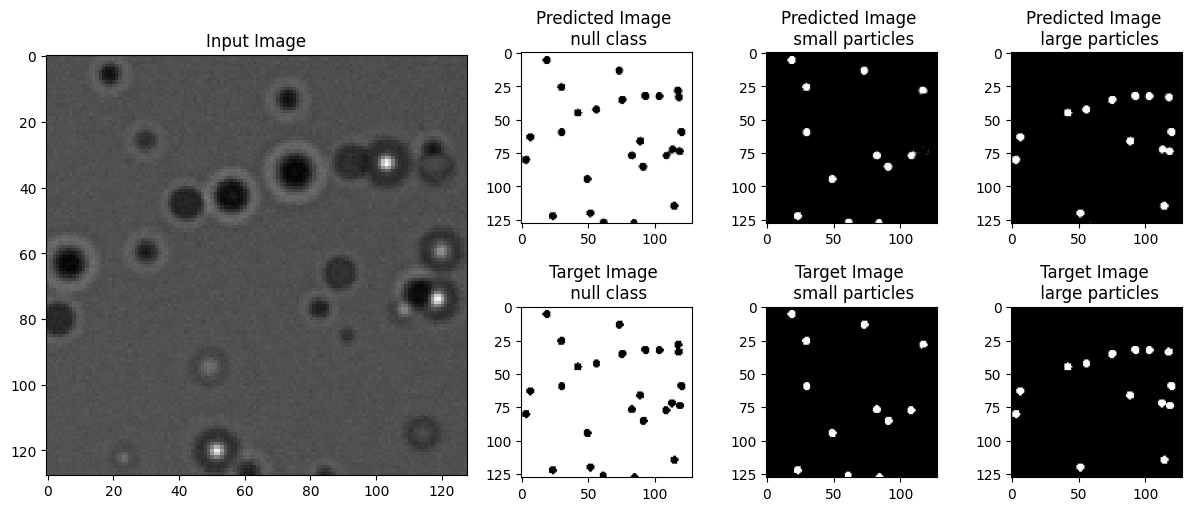

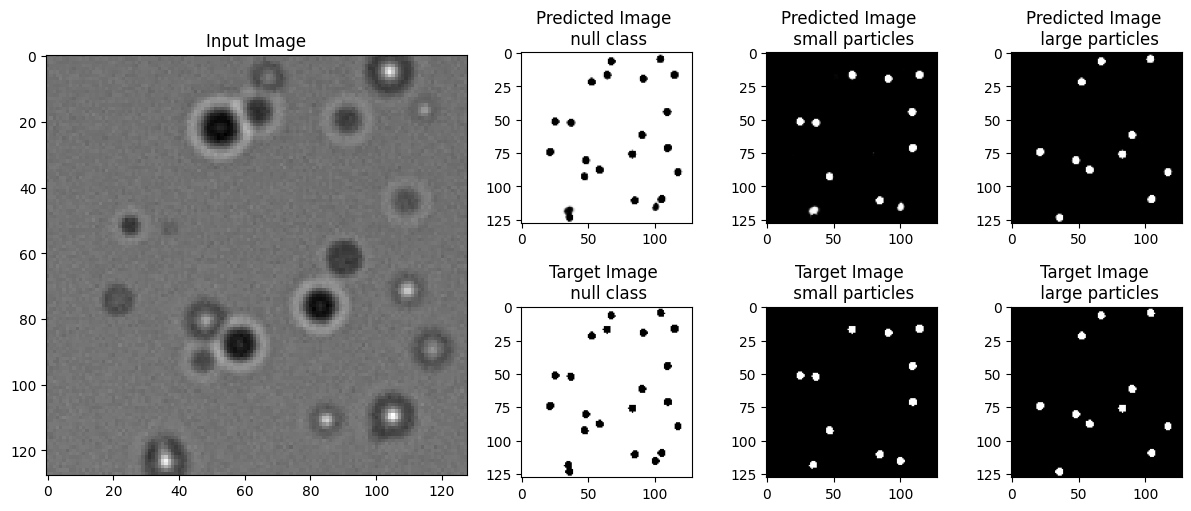

In [16]:
input_image, target_image = data_pipeline.batch(4)

predicted_image = unet_reg.predict(input_image).softmax(1)

for i in range(input_image.shape[0]):
    
    fig = plt.figure(figsize=(12, 5), constrained_layout=True)

    gs = fig.add_gridspec(2, 5)

    fig.add_subplot(gs[0:2, 0:2])
    plt.imshow(input_image[i, 0, ...], cmap="gray")
    plt.title("Input Image")


    fig.add_subplot(gs[0, 2])
    plt.imshow(predicted_image[i, 0], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image \n null class")
    
    fig.add_subplot(gs[0, 3])
    plt.imshow(predicted_image[i, 1], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image \n small particles")
    
    fig.add_subplot(gs[0, 4])
    plt.imshow(predicted_image[i, 2], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image \n large particles")

    
    fig.add_subplot(gs[1, 2])
    plt.imshow(target_image[i] == 0, cmap="gray")
    plt.title("Target Image \n null class")
    
    fig.add_subplot(gs[1, 3])
    plt.imshow(target_image[i] == 1, cmap="gray")
    plt.title("Target Image \n small particles")
    
    fig.add_subplot(gs[1, 4])
    plt.imshow(target_image[i] == 2, cmap="gray")
    plt.title("Target Image \n large particles")  

    plt.show()